In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from functools import reduce
from scipy import stats

In [2]:
directory = '../../../Chapters/tables/'
color_pallette = 'muted' #muted deep bright pastel dark colorblind

def getSystemPriority():
    clients = pd.read_csv("../data/uat_raw/clientUsers.csv")
    employees = pd.read_csv("../data/uat_raw/employeUsers.csv")

    # Merge the two dataframes based on matching SubSystemId values
    merged_df = pd.merge(clients, employees, on='SubSystemId', how='outer', suffixes=('_df1', '_df2'))

    # Replace any NaN values with 0
    merged_df.fillna(0, inplace=True)

    # Calculate TotalUserCount where UserCount values are equal
    merged_df['TotalUserCount'] = merged_df.apply(lambda row: row['UserCount_df1'] + row['UserCount_df2'], axis=1)

    return merged_df

def getBaseProjectDataC():
    """
    Gets the base data for the project

    Returns:
    A dataframe with user activities
    """
    projectBaseData = pd.DataFrame()  # Initialize an empty dataframe

    for i in range(2, 9):  # Loop over file names "uat2" to "uat8"
        filename = f"../data/uat_raw/uat{i}.csv"
        data = pd.read_csv(filename)
        projectBaseData = pd.concat([projectBaseData, data], ignore_index=True) 

    systemsData = pd.read_csv("../data/uat_raw/unique_systems.csv")
    users = pd.read_csv("../data/uat_raw/users.csv")
    temp = pd.merge(systemsData, projectBaseData, on='Controller')
    temp = pd.merge(users, temp, on='UserId')

    # Calculate Priority based on total users linked to a subsystem
    subsystem_users = temp.groupby('SubSystemId')['UserId'].nunique()
    temp['TotalUserCount'] = temp['SubSystemId'].map(subsystem_users)

    return temp

def getBaseProjectData(file):
    """
    Gets the base data for the project

    Returns:
    A dataframe with user activities
    """
    systemsData = pd.read_csv("../data/uat_raw/systems.csv")
    projectBaseData = pd.read_csv(f"../data/uat_raw/{file}.csv")
    priority = getSystemPriority()
    users = pd.read_csv("../data/uat_raw/users.csv")

    temp = pd.merge(systemsData, projectBaseData,on='SubSystemId')
    temp = pd.merge(users, temp, on='UserId')
    temp = pd.merge(priority, temp, on='SubSystemId')

    return temp.loc[(temp['Project'] == 1) & (temp['Deleted'] == 1)], temp.loc[(temp['Project'] == 2) & (temp['Deleted'] == 1)];

def getNormalisedByTotal(data):
    temp = data.groupby(['SubSystemId']).agg(
        TotalUserCount=('TotalUserCount', 'mean'),
        Count=('SubSystemId', 'count')
    ).reset_index()

    # Normalize TotalUserCount
    min_total_user_count = temp['TotalUserCount'].min()
    max_total_user_count = temp['TotalUserCount'].max()
    temp['Priority'] = (temp['TotalUserCount'] - min_total_user_count) / (max_total_user_count - min_total_user_count)

    # Normalize Count
    min_count = temp['Count'].min()
    max_count = temp['Count'].max()
    temp['NormalisedCount'] = (temp['Count'] - min_count) / (max_count - min_count)

    # Calculate MaintenanceFactor
    temp['MaintenanceFactor'] = temp['NormalisedCount'] * temp['Priority']

    return temp

def getNormilisedBySecondCriteria(data, secondFilter):
    temp = data.groupby(['SubSystemId',secondFilter]).agg(TotalUserCount=('TotalUserCount', 'mean'),
     Count=('SubSystemId', 'count')).reset_index()

    min_count = temp['TotalUserCount'].min()
    max_count = temp['TotalUserCount'].max()

    temp['Priority'] = temp['TotalUserCount'].apply(lambda x: 
        (x-min_count)/(max_count-min_count))

    # get the number of unique entries in the 'ActivityType' column
    num_activity_types = data[secondFilter].nunique()

    # get the first 'Priority' value for each 'SubSystemId'
    first_priority = temp.groupby('SubSystemId')['Priority'].first()

    # pivot the table and merge with the first priority values
    pivoted_df = temp.pivot_table(index='SubSystemId', columns=secondFilter, values='Count', fill_value=0)
    pivoted_df = pivoted_df.merge(first_priority, left_index=True, right_index=True).reset_index()

    # get all unique entries in the 'x' column
    unique_values = data[secondFilter].unique()

    for name in unique_values:
        normalised_table_name = f'NormalisedCount_{name}'
        maintenance_table_name = f'MaintenanceFactor_{name}'
        pivoted_min = pivoted_df[name].min()
        pivoted_max = pivoted_df[name].max()

        # calculate the normalized count
        pivoted_df[normalised_table_name] = (pivoted_df[name] - pivoted_min) / (pivoted_max - pivoted_min)

        # calculate the maintenance factor
        pivoted_df[maintenance_table_name] = pivoted_df[normalised_table_name] * pivoted_df['Priority']

    return pivoted_df

def mergedColumns(data, secondFilter):
    temp = getNormalisedByTotal(data)
    temp2 = getNormilisedBySecondCriteria(data, secondFilter)
    columns_to_keep = data['ActivityType'].unique().tolist()
    columns_to_keep.append('SubSystemId')

    merged_df = pd.merge(temp, temp2[columns_to_keep], on='SubSystemId')
    return merged_df

In [3]:
# Get project actvities
projectB, projectA = getBaseProjectData('uat1')
projectC = getBaseProjectDataC()

# Get project total activities per project
projectA_Normilised = mergedColumns(projectA, 'ActivityType')
projectB_Normilised = mergedColumns(projectB, 'ActivityType')
projectC_Normilised = mergedColumns(projectC, 'ActivityType')

# Test data
testA, testB = getBaseProjectData('test_data')

# Get project total activities per project
testB_Normilised = getNormalisedByTotal(testB)

In [4]:
def createLatexRows(data, filename, caption, testData, fullData = True):
    data = data.sort_values(by='MaintenanceFactor', ascending=False)

    # select the top 25 entries
    #data = data.head(40)

    #data = data.sort_values(by='SubSystemId', ascending=True)
    data['rank'] = data['MaintenanceFactor'].rank(method='min', ascending=False)

    latex_rows = ''
    for index, row in data.iterrows():
        systemId = f"$S_{index+1}$" if testData else f"$S_{{{int(row['SubSystemId'])}}}$"
        
        if fullData:
            latex_rows += '\n {:s} & {:d} & {:.4f} & {:d} & {:.4f} & {:.4f} & {:d} \\\ \\hline'.format(systemId, int(row['TotalUserCount']) ,row['Priority'], int(row['Count']), row['NormalisedCount'], row['MaintenanceFactor'], int(row['rank']))
        else:
            latex_rows += '\n {:s} & {:.4f} & {:.4f} & {:.4f} & {:d} \\\ \\hline'.format(systemId, row['Priority'], row['NormalisedCount'], row['MaintenanceFactor'], int(row['rank']))

    columns = "|X|X|X|X|X|X|X|" if fullData else "|X|X|X|X|X|"
    column_names = r"""\textbf{$S_{X}$} & \textbf{$P_X$} & \textbf{$P_N$}  & \textbf{$A_X$} & \textbf{$A_N$} & \textbf{$M_{PF}$} & \textbf{$P_{R}$} \\""" if fullData else r"""\textbf{$S_{X}$} & \textbf{$P_N$}  & \textbf{$A_N$} & \textbf{$M_{PF}$} & \textbf{$P_{R}$} \\"""

    column_amount = "7" if fullData else "5"

    header = r"""
    \begin{xltabular}{\textwidth}{%s}
        \caption[%s]
        {\textit{%s}}
        \label{tbl:apx_%s} \\
        \hline
         %s
        \hline
        \endfirsthead

        \multicolumn{%s}{c}
        {\tablename\ \thetable{} -- continued from previous page} \\
        \hline
        %s
        \endhead

        \multicolumn{%s}{|r|}{{Continued on next page}} \\ \hline
        \endfoot

        \hline
        \endlastfoot
    """ % (columns, caption, caption, filename, column_names, column_amount, column_names, column_amount) 
    
    table = header + latex_rows.strip() + r"""
    \end{xltabular}
    """

    filepath = directory + filename + '.tex'

    # Write the latex_rows string to the file
    with open(filepath, 'w') as f:
        f.write(table)


createLatexRows(projectA_Normilised, "projectA_Normilised", "Case study A results", False)
createLatexRows(projectB_Normilised, "projectB_Normilised", "Case study B results", False)
createLatexRows(projectC_Normilised, "projectC_Normilised", "Case study C results", False)

# Test data 
createLatexRows(testB_Normilised, "testB_Normilised", "Test data", True)

In [5]:
def createFigures(data, case, stackedColumns):
    # Sort the dataframe by the 'Count' column in descending order
    #data = data.sort_values(by='Count', ascending=False)

    # Select the top 40 entries
    # Calculate the quartiles
    q1 = data['Count'].quantile(0.25)
    q3 = data['Count'].quantile(0.75)

    # Filter the data based on the quartiles
    filtered_data = data[(data['Count'] >= q3)]

    # Sort the dataframe by the 'SubSystemId' column
    filtered_data = filtered_data.sort_values(by='SubSystemId')

    # Create latex table
    table_name = f"case{case}"
    table_heading = f"Case study {case}'s upper quartile maintenance pefromance"
    createLatexRows(filtered_data, table_name, table_heading, False, False)

    sns.set(style="darkgrid")
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["figure.figsize"] = (16, 9)

    # Get the unique SubSystemIds
    subsystem_ids = filtered_data['SubSystemId'].unique()

    # Set the number of subsystems to show per graph
    num_subsystems_per_graph = 300

    # Calculate the number of graphs needed
    num_graphs = int(np.ceil(len(subsystem_ids) / num_subsystems_per_graph))

    filtered_data['SS_SystemId'] = '$S_{' + filtered_data['SubSystemId'].astype(str) + '}$'

    # Define a software color palette
    colors = sns.color_palette(color_pallette, n_colors=len(stackedColumns))

    # Loop through each graph
    for i in range(num_graphs):
        start_index = i * num_subsystems_per_graph
        end_index = min((i + 1) * num_subsystems_per_graph, len(subsystem_ids))
        current_ids = subsystem_ids[start_index:end_index]

        # Filter the data to show only the current subsystem ids
        current_data = filtered_data[filtered_data['SubSystemId'].isin(current_ids)]

        # Create figure and axis objects with subplots()
        fig, ax = plt.subplots()

        # Plot the stacked bar chart
        current_data.plot(kind='bar', x='SS_SystemId', y=stackedColumns, stacked=True, ax=ax, color=colors)

        ax.set_ylabel('User activities')

        # Set the x-axis label and tick label rotation
        ax.set_xlabel(r'Subsystem $S_X$')
        plt.xticks(rotation='45', ha='right')

        # Add a legend
        ax.legend()

        # Add a title to the chart
        plt.title(f'Subsystem vs. User activities and Maintenance Factor')

        # Save the current figure
        plt.savefig(f'../../../img/ch3/analysis/case_{case}_subsystems_{i + 1}.pdf', format="pdf", bbox_inches="tight")

        # Close the figure to free memory
        plt.close(fig)

# Example usage
createFigures(projectA_Normilised, 'A', projectA['ActivityType'].unique().tolist())
createFigures(projectB_Normilised, 'B', projectB['ActivityType'].unique().tolist())
createFigures(projectC_Normilised, 'C', projectC['ActivityType'].unique().tolist())

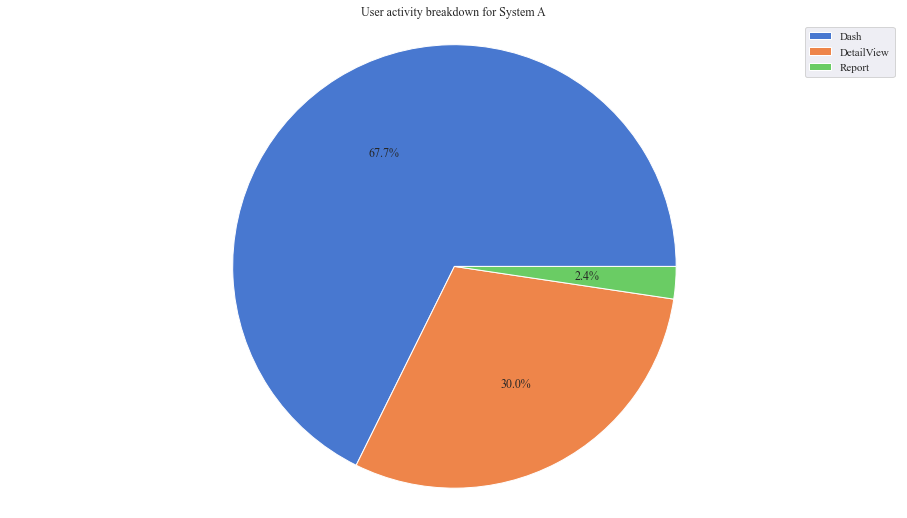

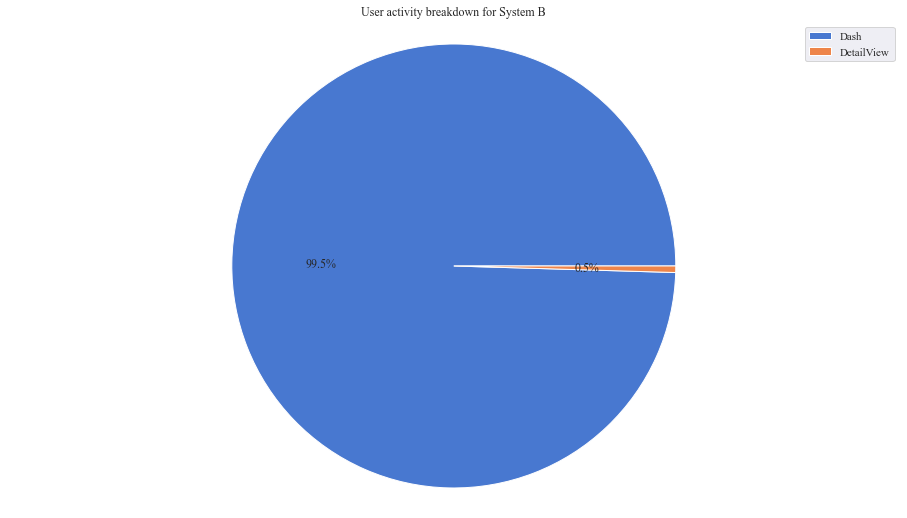

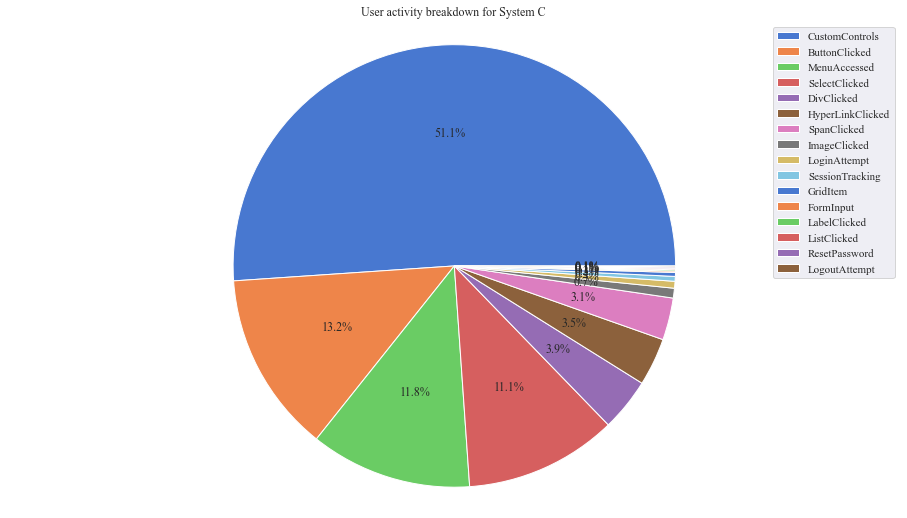

In [6]:
def uatBreakdown(data, label):
    # Count the occurrences of each category
    category_counts = data['ActivityType'].value_counts()

    # Define Seaborn color palette to use
    colors = sns.color_palette(color_pallette, n_colors=len(category_counts))

    # Create a new figure
    plt.figure()

    # Plotting a pie chart
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["figure.figsize"] = (16, 9)
    plt.pie(category_counts, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')  # Ensure that pie is drawn as a circle
    plt.title('User activity breakdown for System ' + label)

    # Add a legend
    plt.legend(category_counts.index)

    # Save the current figure
    plt.savefig(f'../../../img/ch3/analysis/case_{label}_breakdown.pdf', format="pdf", bbox_inches="tight")


uatBreakdown(projectA, 'A')
uatBreakdown(projectB, 'B')
uatBreakdown(projectC, 'C')

In [7]:
# Convert the 'Controller' column to string data type
projectC['Controller'] = projectC['Controller'].astype(str)

unique_controllers = projectC['Controller'].unique().tolist()

# Sort the unique controllers alphabetically
unique_controllers_sorted = sorted(unique_controllers)

# Create a new DataFrame with the sorted unique controllers
unique_controllers_df = pd.DataFrame({'Unique Controllers': unique_controllers_sorted})

# Save the DataFrame as a CSV file
unique_controllers_df.to_csv('../data/uat_raw/unique_controllers.csv', index=False)